Tasks:

1. Identify invoices with unusually high or low total sales.
2. Detect any anomalies in sales trends (e.g., sudden drops or spikes).

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df1= pd.read_excel("C:/Users/prash/Desktop/data/online_retail_II.xlsx", sheet_name='Year 2009-2010')
df2= pd.read_excel('C:/Users/prash/Desktop/data/online_retail_II.xlsx', sheet_name='Year 2010-2011')
df = pd.concat([df1, df2], ignore_index=True)

# Data Cleaning- negative values to positive values
df['Quantity'] = df['Quantity'].abs()
df['Price'] = df['Price'].abs()

# Adding revenue column
df['TotalPrice'] = df['Quantity'] * df['Price']

# Removing bad data(not related to online retail sales)- got this data after doing product analysis
scanlist=['Manual','AMAZON FEE','DOTCOM POSTAGE','Adjust bad debt', 'POSTAGE']
df = df[~df['Description'].isin(scanlist)]

# Ensure the date column is in datetime format
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Extract year, month, quarter, week number, and day of the week
df['Year'] = df['InvoiceDate'].dt.year
df['Month'] = df['InvoiceDate'].dt.month
df['Quarter'] = df['InvoiceDate'].dt.quarter
df['WeekNumber'] = df['InvoiceDate'].dt.isocalendar().week  # Week number
df['DayOfWeek'] = df['InvoiceDate'].dt.day_name()  # Day of the week as a string

# Drop duplicates
df.drop_duplicates(inplace=True) 

# Removing bad data with total price null and where prices can't be assigned
# df=df[df['TotalPrice']!=0]

In [28]:
invoice_val=df.groupby(['Invoice'])['TotalPrice'].sum().sort_values(ascending=False).head(10).reset_index()

In [29]:
invoice_val

,Invoice,TotalPrice
0,581483,168469.60
1,C581484,168469.60
2,541431,77183.60
3,C541433,77183.60
4,574941,52940.94
5,576365,50653.91
6,533027,49844.99
7,531516,45332.97
8,493819,44051.60
9,556444,38970.00


In [17]:
df[df['Invoice'].isin(invoice_val['Invoice'][:4])]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice,Year,Month,Quarter,WeekNumber,DayOfWeek
587080,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346.0,United Kingdom,77183.6,2011,1,1,3,Tuesday
587085,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:17:00,1.04,12346.0,United Kingdom,77183.6,2011,1,1,3,Tuesday
1065882,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.08,16446.0,United Kingdom,168469.6,2011,12,4,49,Friday
1065883,C581484,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:27:00,2.08,16446.0,United Kingdom,168469.6,2011,12,4,49,Friday


High TotalPrice invoices seem alright!

In [20]:
invoice_deval=df.groupby(['Invoice'])['TotalPrice'].sum().sort_values(ascending=True).head(10).reset_index()
invoice_deval

,Invoice,TotalPrice
0,489463,0.0
1,512883,0.0
2,512884,0.0
3,512885,0.0
4,512887,0.0
5,512908,0.0
6,512918,0.0
7,526258,0.0
8,502034,0.0
9,559503,0.0


Most of the invoices have totalprice or totalsales value as 0. Something seems fishy- need to inspect or remove unnecessary data

In [24]:
df[df['TotalPrice']==0]['Description'].value_counts().head(10)

Description
check                    160
?                         90
damages                   83
damaged                   81
found                     28
missing                   27
sold as set on dotcom     20
Damaged                   17
adjustment                16
OWL DOORSTOP              14
Name: count, dtype: int64

These are bad values and need to be removed as we can't even assign new prices to them as Description is bad data!

In [26]:
df=df[df['TotalPrice']!=0]

Anamoly detection in sales trends

In [31]:
df['Year'].unique()

array([2009, 2010, 2011], dtype=int32)

Let's look at week wise sales trends in 2009, 2010 and 2011

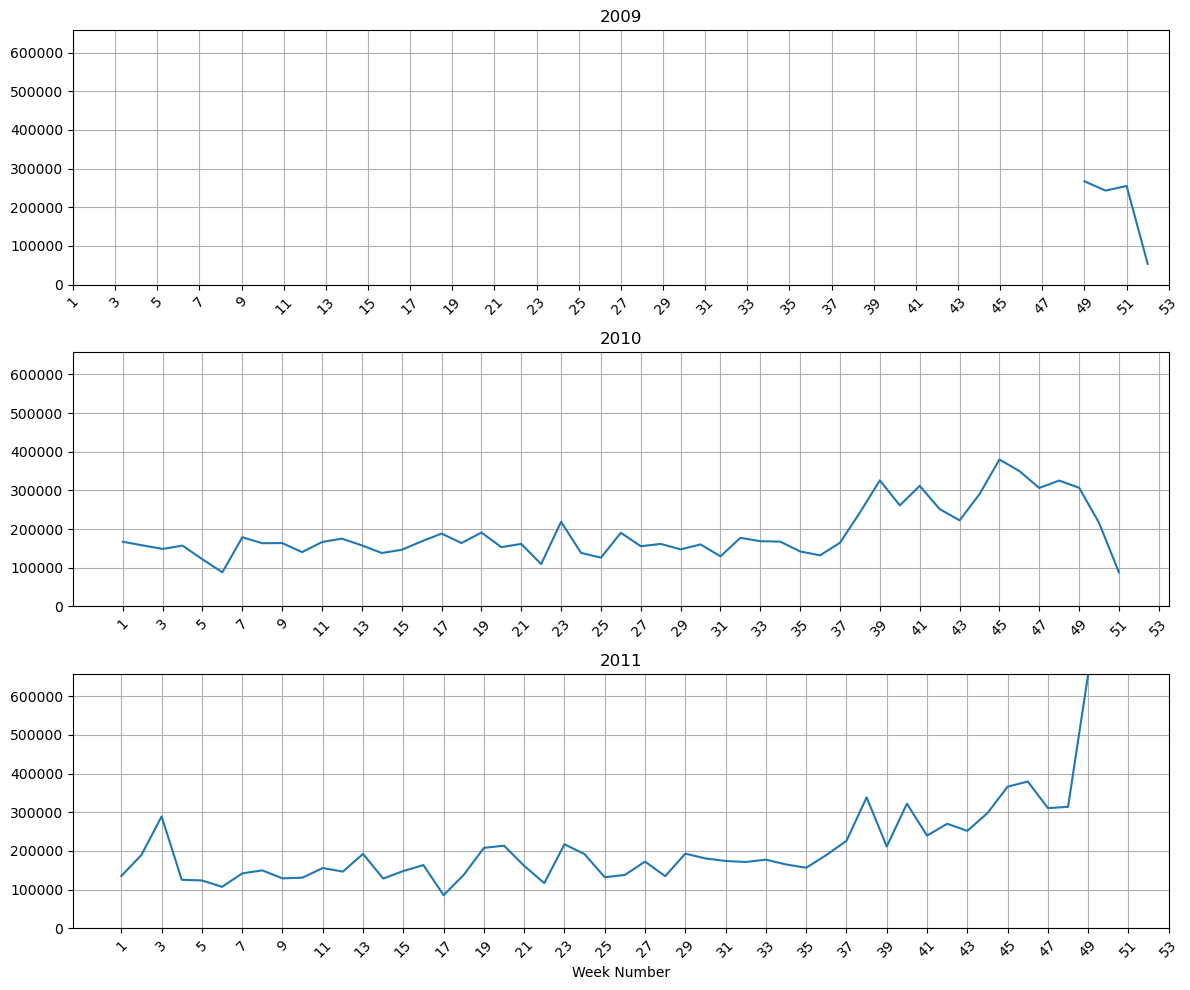

In [47]:
fig,ax= plt.subplots(len(df['Year'].unique()),1,figsize=(12, 10))

# Define common y-axis limits
y_min = 0
y_max = df.groupby(['Year','WeekNumber'])['TotalPrice'].sum().max()  # Set max based on data

for i,year in enumerate(df['Year'].unique()):
    df[df['Year']==year].groupby('WeekNumber')['TotalPrice'].sum().plot(ax=ax[i],title=year,legend=False)
    #ax[i].set_ylabel('Total Sales')
    #ax[i].set_xlabel('Week Number')
    ax[i].set_xticks(range(1, 54, 2))  # Set x-ticks to show every second week number
    ax[i].set_xticklabels(range(1, 54, 2), rotation=45)  # Rotate x-tick labels for better readability
    ax[i].grid(True) # Add grid for better readability
    ax[i].set_ylim(y_min, y_max)  
     # Remove x-label for all subplots except the last one
    if i != (len(df['Year'].unique()) - 1):
        ax[i].set_xlabel('')  # Remove x-label for all but the last subplot
    else:
        ax[i].set_xlabel('Week Number')

plt.tight_layout()
plt.show()

In 2009 there is not much data, so can't infer much. Maybe a severe drop in sales or lack of data from week 52 onwards.
In 2010, there is spike in sales from week 39-49, then a sudden drop from week 50 and maybe lack of data from week 51 and beyond.
2011 witnessed a spike in week 3 in 50% increase in sales as compared to week 2 and similar sales spike around the same period as in 2010- week 38 - 49. But in week 49 it has skyrocketed with no data for weeks beyond that. 

In [30]:
df

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice,Year,Month,Quarter,WeekNumber,DayOfWeek
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.40,2009,12,4,49,Tuesday
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.00,2009,12,4,49,Tuesday
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.00,2009,12,4,49,Tuesday
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.80,2009,12,4,49,Tuesday
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.00,2009,12,4,49,Tuesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1067365,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,10.20,2011,12,4,49,Friday
1067366,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,12.60,2011,12,4,49,Friday
1067367,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60,2011,12,4,49,Friday
1067368,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60,2011,12,4,49,Friday
